An early time/value comparison. Somehow the match here is very good (not known why, bug or not?).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt
import time

import capytaine as cpt

import sys
import os
sys.path.append(os.path.relpath('../../'))
from multi_condensed import Problem

# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)

In [2]:
m0_nums_MEEM = np.concatenate((np.linspace(0.1, 1, 20), np.linspace(1, 6, 20)))

# Some slant bicylinder

def makeSlant(d1, d2, a1, a2, resolu, terms):
    d = np.linspace(d1, d2, resolu)
    a = a1 + (d1-d) * (a2-a1) / (d1-d2)
    heaving = np.ones(resolu, dtype=int)
    NMK = np.full(resolu+1, terms) 
    return d.tolist(), a.tolist(), heaving.tolist(), NMK.tolist()

resolu = 25 #number of mini cylinders the slant object has
terms = 50 #number of terms in each region
d, a, heaving, NMK = makeSlant(0.5, 0.25, 0.25, 0.5, resolu, terms)

# m0 = 1.0
h = 1.001
g = 9.81
rho = 1023
####################################################

In [3]:
############################################## MEEM ############################################################
hydro_collector_real_MEEM = []
hydro_collector_imag_MEEM = []
hydro_nondim_real_diff = [np.nan]
hydro_nondim_imag_diff = [np.nan]
times_MEEM = []
loop_num = 0

for m0 in m0_nums_MEEM:
    start = time.perf_counter()
    prob = Problem(h, d, a, heaving, NMK, m0, rho)
    a0 = prob.a_matrix()
    b0 = prob.b_vector()
    x = prob.get_unknown_coeffs(a0, b0)
    am, dp = prob.hydro_coeffs(x, "nondimensional")
    hydro_collector_real_MEEM.append(am)
    hydro_collector_imag_MEEM.append(dp)
    end = time.perf_counter()
    times_MEEM.append(end - start)

    if loop_num != 0:
        hydro_nondim_real_diff.append((hydro_collector_real_MEEM[loop_num]-hydro_collector_real_MEEM[loop_num-1])/hydro_collector_real_MEEM[loop_num-1])
        hydro_nondim_imag_diff.append((hydro_collector_imag_MEEM[loop_num]-hydro_collector_imag_MEEM[loop_num-1])/hydro_collector_imag_MEEM[loop_num-1])
    # if loop_num != 0:
    #     percent_diff_real = abs((186621534261.50247 - hydro_collector_real[loop_num-1])/186621534261.50247)
    #     percent_diff_imag = abs((3529258.9182286593 - hydro_collector_imag[loop_num-1])/3529258.9182286593)
    #     if percent_diff_real <= 0.001 and percent_diff_imag <= 0.001:
    #         break
    #     if times_MEEM[-1] > 11.94:
    #         break
    
    loop_num += 1



In [4]:
def deafen(function, *args):
    real_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    output = function(*args)
    sys.stdout = real_stdout
    return output

solver = cpt.BEMSolver(engine=cpt.HierarchicalToeplitzMatrixEngine())

def timed_solve(problem, reps):
    t_lst = []
    for i in range(reps):
        t0 = time.perf_counter()
        result = solver.solve(problem, keep_details = True)
        t1 = time.perf_counter()
        t_lst.append(t1 - t0)
    tdiff = sum(t_lst)/reps
    return result, tdiff

def get_points(a, d): # These points define the outline of the body
    d_prime = d + [0]
    d_index = 0
    a_index = 0
    pt_lst = [(0, - d[0])]
    for i in range(len(a)):
        pt_lst.append((a[a_index], - d_prime[d_index]))
        d_index +=1
        pt_lst.append((a[a_index], - d_prime[d_index]))
        a_index+=1
    return pt_lst

# compute number of panels along each surface given total number along the outline
def get_f_densities(pt_lst, total_units):
    face_lengths = np.array([])
    for i in range(len(pt_lst) - 1):
        p1, p2 = pt_lst[i], pt_lst[i + 1]
        face_length = abs(p2[0] - p1[0]) + abs(p2[1] - p1[1]) # one of these two values will be zero
        face_lengths = np.append(face_lengths, face_length)
    total_length = sum(face_lengths)
    each_face_densities = np.vectorize(lambda x: max(1, x/total_length * total_units))(face_lengths) # each face needs at least one panel
    remainders = each_face_densities % 1
    each_face_densities = each_face_densities.astype(int)
    remaining_units = total_units - sum(each_face_densities)
    if remaining_units < 0: # high proportion of small faces
        for u in range(remaining_units * -1):
            i = np.argmax(each_face_densities) # cut density from the largest faces
            each_face_densities[i] = (each_face_densities[i]) - 1
    else:
        for u in range(remaining_units): # distribute remaining units where most needed
            i = np.argmax(remainders)
            each_face_densities[i] = (each_face_densities[i]) + 1
            remainders[i] = 0
    assert sum(each_face_densities) == total_units
    return each_face_densities
    
def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(rarr,rarr,zarr)])
    return cpt.AxialSymmetricMesh.from_profile(xyz, nphi = t_density)

def faces_and_heaves(heaving, region, p1, p2, f_density, t_density, meshes, mask, panel_ct):
    mesh = make_face(p1, p2, f_density, t_density)
    meshes += mesh
    new_panels = f_density * t_density
    if heaving[region]:
        direction = [0, 0, 1]
    else:
        direction = [0, 0, 0]
    for i in range(new_panels):
        mask.append(direction)
    return meshes, mask, (panel_ct + new_panels)

def get_excitation_phase(result):
    return np.angle((cpt.assemble_dataset([result]))["excitation_force"][0][0][0])

def make_body(pts, t_densities, f_densities, heaving):
    meshes = cpt.meshes.meshes.Mesh()
    panel_ct = 0
    mask = []
    for i in range((len(pts) - 1) // 2):
        p1, p2, p3 = pts[2 * i], pts[2 * i + 1], pts[2 * i + 2]
        # make a horizontal face
        meshes, mask, panel_ct = faces_and_heaves(heaving, i, p1, p2, f_densities[2 * i], t_densities[i], meshes, mask, panel_ct)
        # make a vertical face
        if p2[1] < p3[1]: # body on left
            region = i
        else: # body on right
            region = i + 1
        meshes, mask, panel_ct = faces_and_heaves(heaving, region, p2, p3, f_densities[2 * i + 1], t_densities[region], meshes, mask, panel_ct)
    body = deafen(cpt.FloatingBody, meshes) # unclosed boundary warnings
    return body, panel_ct, mask

###################################
# Solving
def rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho, reps):
    pt_lst = get_points(a, d)
    f_densities = get_f_densities(pt_lst, face_units)
    
    body, panel_count, mask = make_body(pt_lst, t_densities, f_densities, heaving)
    body.dofs["Heave"] = mask  
    # body.show_matplotlib() # uncomment to show mesh
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result, t_diff = timed_solve(rad_problem, reps)

    #diff_problem = cpt.DiffractionProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    #result_d, t_diff_d = timed_solve(diff_problem, reps)

    g = 9.81
    omega = np.sqrt(m0*np.tanh(m0*h)*g)

    am = np.array(list(result.added_mass.values()))
    dp = np.array(list(result.radiation_damping.values()))
    am_nondim = h**3 / (rho * np.pi * max(a)**3) * am
    dp_nondim = h**3 / (omega * rho * np.pi * max(a)**3) * dp

    print("Panel Count: ", panel_count)
    #print(result.added_mass)
    #print(result.radiation_damping)
    #print("Solve Time (Radiation): ", t_diff)
    #print("Solve Time (Diffraction): ", t_diff_d)
    #print("Excitation Phase: ", get_excitation_phase(result_d))
    return am, dp, am_nondim, dp_nondim

t_densities = np.full(resolu, 50).tolist() # number of panels around each cylinder
face_units = 50 # number of panels along the outline of the configuration
m0_nums_CPT = np.concatenate((np.linspace(0.1, 1, 5), np.linspace(1, 6, 10)))
results = [rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho, 1) for m0 in m0_nums_CPT]

hydro_collector_real_CPT = [res[2].flatten() for res in results]
hydro_collector_imag_CPT = [res[3].flatten() for res in results]


Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500
Panel Count:  2500


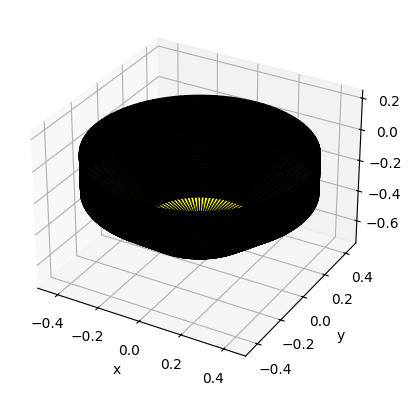

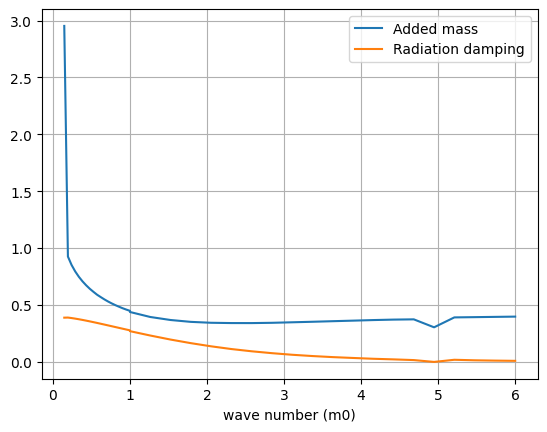

In [5]:
############################################## CAPYTAINE Real Slant ############################################################

# Profile of the axisymmetric body
def shape(z):
    if z >= -0.25:
        return 0.5
    elif z < -0.25 and z >= -0.49999:
        return z + 0.75
    elif z < -0.49999 and z <= -0.5:
        return 25000*z+12500 #approximating a the bottom surface

# Generate the mesh and display it with VTK.
buoy = cpt.FloatingBody(
    mesh=cpt.AxialSymmetricMesh.from_profile(shape, z_range=np.linspace(-0.5, 0, 100), nphi=100)
)
buoy.add_translation_dof(name="Heave")
buoy.show_matplotlib()

# Set up problems
m0_nums_CPT_slant = np.concatenate((np.linspace(0.1, 1, 20), np.linspace(1, 6, 20)))
problems = [cpt.RadiationProblem(body=buoy, radiating_dof='Heave', wavenumber = m0, water_depth = h, rho = rho)
            for m0 in m0_nums_CPT_slant]

# Solve the problems using the axial symmetry
solver = cpt.BEMSolver(engine=cpt.HierarchicalToeplitzMatrixEngine())

results = []
times_CPT = []
for pb in problems:
    t0 = time.perf_counter()
    res = solver.solve(pb)
    t1 = time.perf_counter()

    results.append(res)
    times_CPT.append(t1 - t0)
    
dataset = cpt.io.xarray.assemble_dataset(results)

h = 1.001
rho = 1023  # density of our special material
g = 9.81
omega = dataset['omega']
# omega = sqrt(m0 * np.tanh(m0 * h) * g)
A = dataset['added_mass'].sel(radiating_dof='Heave',influenced_dof='Heave')
B = dataset['radiation_damping'].sel(radiating_dof='Heave', influenced_dof='Heave')
A_nondim = h**3 / (rho * np.pi * 0.5**3) * A                # 0.5 is the radius of the slant object
B_nondim = h**3 / (omega * rho * np.pi * 0.5**3) * B        # 0.5 is the radius of the slant object
# Plot results
plt.figure()
plt.plot(m0_nums_CPT_slant[1:], A_nondim, label="Added mass")
plt.plot( m0_nums_CPT_slant[1:], B_nondim, label="Radiation damping")
plt.xlabel('wave number (m0)')
plt.grid()
plt.legend()
plt.show()

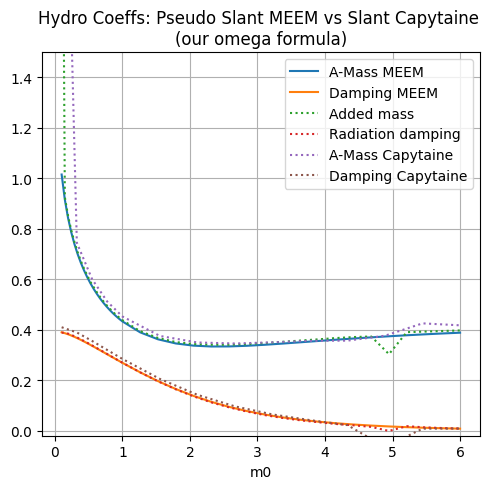

In [7]:
# Create the hydro comparison plots
m0_nums_CPT_slant = np.concatenate((np.linspace(0.1, (1-0.9/19), 19), np.linspace(1, 6, 20)))
plt.figure(figsize=(5,5))
plt.plot(m0_nums_MEEM, hydro_collector_real_MEEM, label='A-Mass MEEM', linestyle='-')
plt.plot(m0_nums_MEEM, hydro_collector_imag_MEEM, label='Damping MEEM', linestyle='-')
plt.plot(m0_nums_CPT_slant, A_nondim, label="Added mass", linestyle=':') #somehow m0_nums_CPT is one element shorter
plt.plot( m0_nums_CPT_slant, B_nondim, label="Radiation damping",linestyle=':') #somehow m0_nums_CPT is one element shorter
plt.plot(m0_nums_CPT, hydro_collector_real_CPT, label='A-Mass Capytaine',  linestyle=':')
plt.plot(m0_nums_CPT, hydro_collector_imag_CPT, label='Damping Capytaine',  linestyle=':') 

plt.xlabel('m0')
plt.ylabel('')
plt.title('Hydro Coeffs: Pseudo Slant MEEM vs Slant Capytaine \n(our omega formula)')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(-0.02, 1.5)

plt.tight_layout()
plt.show()

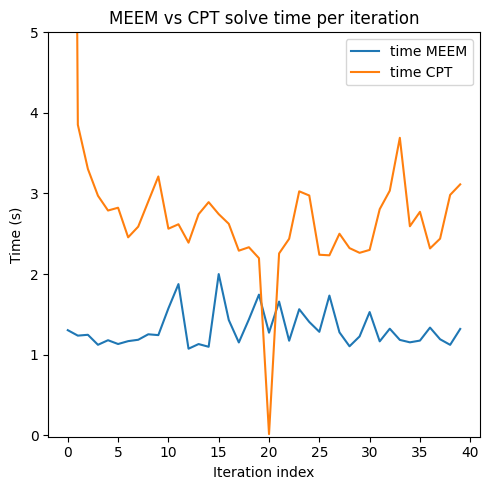

In [8]:
###graphing time difference###
plt.figure(figsize=(5, 5))
plt.plot(times_MEEM, label='time MEEM')
plt.plot(times_CPT, label='time CPT')
plt.xlabel('Iteration index')
plt.ylabel('Time (s)')
plt.title('MEEM vs CPT solve time per iteration')
plt.ylim(-0.02, 5)
plt.legend()
plt.tight_layout()
plt.show()

# Not pictured: despite having less panels, the cpt pseudo slant takes much longer to run than cpt slant
# This is likely an inefficiency in our code.